In [14]:
import requests
import pandas as pd

url = "https://api.jolpi.ca/ergast/f1/2025/results.json?limit=1000"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    races = data['MRData']['RaceTable']['Races']

    results_list = []

    for race in races:
        for result in race['Results']:
            results_list.append({
                'Round': int(race['round']),
                'Date': race['date'],
                'Race': race['raceName'],
                'Driver': result['Driver']['familyName'],
                'Constructor': result['Constructor']['name'],
                'Grid': int(result['grid']),
                'Position': int(result['position']),
                'Status': result['status'],
                'Points': float(result['points'])
            })

    df = pd.DataFrame(results_list)
    print(df.head())
else:
    print(f"Erreur {response.status_code} lors de la récupération des données.")

   Round        Date                   Race      Driver Constructor  Grid  \
0      1  2025-03-16  Australian Grand Prix      Norris     McLaren     1   
1      1  2025-03-16  Australian Grand Prix  Verstappen    Red Bull     3   
2      1  2025-03-16  Australian Grand Prix     Russell    Mercedes     4   
3      1  2025-03-16  Australian Grand Prix   Antonelli    Mercedes    16   
4      1  2025-03-16  Australian Grand Prix       Albon    Williams     6   

   Position    Status  Points  
0         1  Finished    25.0  
1         2  Finished    18.0  
2         3  Finished    15.0  
3         4  Finished    12.0  
4         5  Finished    10.0  


In [15]:
# Parse drivers
results = data['MRData']['RaceTable']['Races'][0]['Results']
driver_list = []

for r in results:
    driver = r['Driver']
    number = driver.get('permanentNumber', None)
    name = f"{driver['givenName']} {driver['familyName']}"
    driver_list.append({'Driver': name, 'Number': number})

df_drivers = pd.DataFrame(driver_list)
print(df_drivers)

                   Driver Number
0            Lando Norris      4
1          Max Verstappen     33
2          George Russell     63
3   Andrea Kimi Antonelli     12
4         Alexander Albon     23
5            Lance Stroll     18
6         Nico Hülkenberg     27
7         Charles Leclerc     16
8           Oscar Piastri     81
9          Lewis Hamilton     44
10           Pierre Gasly     10
11           Yuki Tsunoda     22
12           Esteban Ocon     31
13         Oliver Bearman     87
14            Liam Lawson     30
15      Gabriel Bortoleto      5
16        Fernando Alonso     14
17           Carlos Sainz     55
18            Jack Doohan      7
19           Isack Hadjar      6


In [16]:
# Supprimer les abandons (DNF)
df = df[df['Status'] == 'Finished']

# Encodage
df_encoded = pd.get_dummies(df[['Grid', 'Constructor', 'Driver']])
X = df_encoded
y = df['Position'] <= 3  # Exemple : prédire si le pilote finit sur le podium

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédiction
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.875


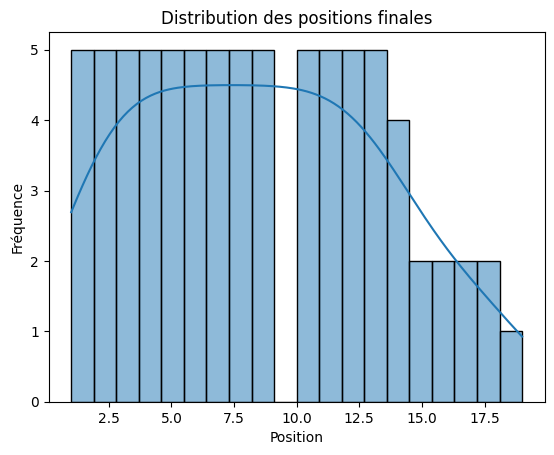

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['Position'], bins=20, kde=True)
plt.title("Distribution des positions finales")
plt.xlabel("Position")
plt.ylabel("Fréquence")
plt.show()

In [19]:
# Exemple de prédiction
import numpy as np

# Créer un DataFrame pour un nouvel échantillon
sample = pd.DataFrame({
    'driver_number': [44],  # Numéro du pilote
    'grid_position': [5],   # Position sur la grille
    'laps': [58],           # Nombre de tours
    'points': [0],          # Points (peut être mis à 0 pour la prédiction)
    # Encodage de l'équipe (assurez-vous que les colonnes correspondent à celles de l'entraînement)
    'constructor_name_Mercedes': [1],
    'constructor_name_Red Bull': [0],
    'constructor_name_McLaren': [0],
    # Ajoutez d'autres équipes si nécessaire
})

# Ajouter les colonnes manquantes avec des zéros
for col in X.columns:
    if col not in sample.columns:
        sample[col] = 0

# Réorganiser les colonnes pour correspondre à l'ordre d'entraînement
sample = sample[X.columns]

# Prédire la position
predicted_position = model.predict(sample)
print(f"Position prédite : {predicted_position[0]:.0f}")


Position prédite : 1
